# Tennis

---

In this notebook we explore the Unity ML-Agents environment, Tennis for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). We solve the environment using DDPG and SAC with a few variations in our multi agent training regime.

## 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment! You will see a new window opening which displays the current view of the environment. As the agent interacts with the environment you will be able to see the activity of the agent. The notebook has been developed on Linux (Ubuntu 18.04) but this should work on Mac and Windows too.

In [2]:
import platform

environment_files = {"Linux":"./Tennis_Linux/Tennis.x86_64"}
env = UnityEnvironment(file_name=environment_files[platform.system()])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

The simulation contains a pair of agents that each control a tennis racket.  At each time step an agent chooses four forces to apply as torques to its two joints. The actions are then a four dimensional vector with values between -1 and 1.

The state space has `26` variables corresponding to position, rotation, velocity, and angular velocities of the two arm Rigidbodies.  A reward of `+0.1` is provided for each timestep that the arm is in goal position.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Action space dimension:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 2
Action space dimension: 2
States look like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
States have length: 24


## 3. Take Random Actions in the Environment

In the next code cell, you will see how to use the Python API to control the agent and receive feedback from the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291


## 4. Train the agents

The cells below setup the code for training agents to solve the environment. We count the environment as solved when the average of the maximum reward sum from each agent is greater than 0.5. We save the policy network weights into pth files.

In [6]:
# Imports and setup plotting
import importlib
import collections
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time

# Agent code
import league
import agent
import agent_pairs

%matplotlib notebook

device = torch.device("cpu")

results = pd.DataFrame(columns =['experiment', 'episode', 'score', 'time_seconds', 'steps']) 

In [7]:
# The main training loop 
def train(league, experiment_name, results, n_episodes=2500):
    start_time = time.monotonic()
    scores = []                        # list containing scores from each episode
    times = []
    steps = []
    scores_window = collections.deque(maxlen=100)  # last 100 scores
    cumulative_steps = 0
    for i_episode in range(1, n_episodes+1):
        score, episode_steps = league.arrange_match()
        cumulative_steps += episode_steps
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        total_time = time.monotonic() - start_time
        times.append(total_time)
        steps.append(episode_steps)
        print('\rEpisode {}\tAverage Score: {:.2f}\tElapsed Time {:.1f} seconds\tCumulative Steps {}'.\
              format(i_episode, np.mean(scores_window), total_time, cumulative_steps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tElapsed Time {:.1f} seconds\tCumulative Steps {}'.\
                  format(i_episode, np.mean(scores_window), total_time, cumulative_steps))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tElapsed Time {:.1f} seconds\tCumulative Steps {}'.\
                  format(i_episode-100, np.mean(scores_window), total_time, cumulative_steps))
            for key, state_dict in league.get_trained_state_dicts().items():
                weights_filename = "weights/" + experiment_name + "-" + key + ".pth"
                torch.save(state_dict, weights_filename)
            break

    experiment = [experiment_name] * len(scores)
    episode = list(range(len(scores)))
    new_df = pd.DataFrame(list(zip(experiment, episode, scores, times, steps)), 
               columns =['experiment', 'episode', 'score', 'time_seconds', 'steps'])
    
    return results.append(new_df) 

### DDPG

For this agent we use a DDPG implementation. The main concepts behind DDPG are as follows:

- Off policy. We use a buffer to store recent experiences and train on mini-batches randomly selected from there.

- Policy provides a direct mapping from state to continuous action.

- To encourage exploration noise is added to the policy action (in this case mean 0 standard deviation Gaussian noise)

$$ \mu_\theta(s) + \epsilon \quad \epsilon \sim \mathcal{N}(0, \sigma^2) $$

- To encourage initial exploration for the first `start_steps` policy evaluations a completely random action is selected (uniformly distributed over the action space).

- Policy network is trained to minimize the KL Divergence between the output of the policy and the value function.

$$ J_{\pi} (\phi) = \mathbb{E}\Big[D_{KL}(\pi_\phi(.|s_t) \Big\| \frac{\exp(Q_\theta(s_t,.))}{Z_\theta(s_t)}\Big]$$

- Target networks are used for both the critic and policy networks in order to improve stability of training. These are lagged copies of the networks updated using polyak averaging:

$$ \phi_{target} = \tau \phi + (1 - \tau) \phi_{target} $$

### Soft Actor Critic

For this agent we use a Soft Actor Critic implementation. The main concepts behind SAC are as follows:

- Off policy. We use a buffer to store recent experiences and train on mini-batches randomly selected from there.

- Policy is output as a Gaussian mean and log standard deviation. To translate to an action `tanh` of a sample of the Normal distribution is calculated.

- Entropy regularized (using alpha as regularisation weight) to encourage exploration.

$$ r(s_t, a_t) + \gamma \mathbb{E}_{a' \sim \pi} [ Q(s_{t+1}, a') - \alpha \log \pi(a'|s_{t+1}) ] $$


- A pair of Q networks are trained with the estimate used for state / action value as the minimum of both. This helps to avoid overestimation of the value function.

- Policy network is trained to minimize the KL Divergence between the output of the policy and the value function.

$$ J_{\pi} (\phi) = \mathbb{E}\Big[D_{KL}(\pi_\phi(.|s_t) \Big\| \frac{\exp(Q_\theta(s_t,.))}{Z_\theta(s_t)}\Big]$$



### Independent Play

This is a very simple approach where we train a pair of agents each of which learns as it plays matches against the opposing agent. One of the downsides is that we end up using only half the total experiences for each agent. For a task like this where we are cooperating (we are rewarded for long rallies) we still solve the environment.

In [8]:
importlib.reload(league)
importlib.reload(agent)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["alpha"] = 0.2
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["a_learn_rate"] = 3e-4
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3

agent1 = agent.SACAgent(device, env, hyperparams)
agent2 = agent.SACAgent(device, env, hyperparams)
results = train(league.IndependentPlayLeague(device, env, agent1, agent2, hyperparams), 'sac-independent', results)

Episode 100	Average Score: 0.02	Elapsed Time 115.6 seconds	Cumulative Steps 1824
Episode 200	Average Score: 0.04	Elapsed Time 303.5 seconds	Cumulative Steps 4059
Episode 300	Average Score: 0.08	Elapsed Time 582.2 seconds	Cumulative Steps 7405
Episode 400	Average Score: 0.10	Elapsed Time 897.6 seconds	Cumulative Steps 11217
Episode 500	Average Score: 0.09	Elapsed Time 1223.1 seconds	Cumulative Steps 15164
Episode 600	Average Score: 0.04	Elapsed Time 1420.4 seconds	Cumulative Steps 17511
Episode 700	Average Score: 0.02	Elapsed Time 1567.1 seconds	Cumulative Steps 19217
Episode 800	Average Score: 0.01	Elapsed Time 1705.1 seconds	Cumulative Steps 20805
Episode 900	Average Score: 0.01	Elapsed Time 1838.9 seconds	Cumulative Steps 22347
Episode 1000	Average Score: 0.01	Elapsed Time 1972.6 seconds	Cumulative Steps 23895
Episode 1100	Average Score: 0.01	Elapsed Time 2098.7 seconds	Cumulative Steps 25332
Episode 1200	Average Score: 0.04	Elapsed Time 2280.7 seconds	Cumulative Steps 27478
Episode 

In [9]:
importlib.reload(league)
importlib.reload(agent)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3
hyperparams["noise_sd"] = 0.1
hyperparams["start_steps"] = 1000

agent1 = agent.DDPGAgent(device, env, hyperparams)
agent2 = agent.DDPGAgent(device, env, hyperparams)
results = train(league.IndependentPlayLeague(device, env, agent1, agent2, hyperparams), 'ddpg-independent', results)

Episode 100	Average Score: 0.01	Elapsed Time 61.7 seconds	Cumulative Steps 1492
Episode 200	Average Score: 0.00	Elapsed Time 141.6 seconds	Cumulative Steps 2812
Episode 300	Average Score: 0.00	Elapsed Time 221.3 seconds	Cumulative Steps 4132
Episode 400	Average Score: 0.01	Elapsed Time 310.9 seconds	Cumulative Steps 5641
Episode 500	Average Score: 0.04	Elapsed Time 439.5 seconds	Cumulative Steps 7837
Episode 600	Average Score: 0.03	Elapsed Time 548.6 seconds	Cumulative Steps 9690
Episode 700	Average Score: 0.02	Elapsed Time 649.6 seconds	Cumulative Steps 11378
Episode 800	Average Score: 0.03	Elapsed Time 759.7 seconds	Cumulative Steps 13236
Episode 900	Average Score: 0.04	Elapsed Time 879.5 seconds	Cumulative Steps 15248
Episode 1000	Average Score: 0.04	Elapsed Time 994.6 seconds	Cumulative Steps 17187
Episode 1100	Average Score: 0.04	Elapsed Time 1116.1 seconds	Cumulative Steps 19236
Episode 1200	Average Score: 0.05	Elapsed Time 1252.8 seconds	Cumulative Steps 21541
Episode 1300	Avera

### Self Play

This is a basic self play where we use the same agent to play both sides of the game. This has the advantage of being efficient in use of samples.

In [10]:
importlib.reload(league)
importlib.reload(agent)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["alpha"] = 0.2
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["a_learn_rate"] = 3e-4
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3

training_agent = agent.SACAgent(device, env, hyperparams)
results = train(league.SelfPlayLeague(device, env, training_agent, hyperparams), 'sac-self-play', results)

Episode 100	Average Score: 0.03	Elapsed Time 140.4 seconds	Cumulative Steps 1897
Episode 200	Average Score: 0.09	Elapsed Time 441.4 seconds	Cumulative Steps 5532
Episode 300	Average Score: 0.06	Elapsed Time 691.9 seconds	Cumulative Steps 8537
Episode 400	Average Score: 0.00	Elapsed Time 809.2 seconds	Cumulative Steps 9882
Episode 500	Average Score: 0.00	Elapsed Time 923.6 seconds	Cumulative Steps 11202
Episode 600	Average Score: 0.00	Elapsed Time 1038.8 seconds	Cumulative Steps 12535
Episode 700	Average Score: 0.08	Elapsed Time 1290.1 seconds	Cumulative Steps 15565
Episode 800	Average Score: 0.13	Elapsed Time 1701.1 seconds	Cumulative Steps 20584
Episode 864	Average Score: 0.52	Elapsed Time 3085.2 seconds	Cumulative Steps 38124
Environment solved in 764 episodes!	Average Score: 0.52	Elapsed Time 3085.2 seconds	Cumulative Steps 38124


In [11]:
importlib.reload(league)
importlib.reload(agent)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3
hyperparams["noise_sd"] = 0.1
hyperparams["start_steps"] = 1000

training_agent = agent.DDPGAgent(device, env, hyperparams)
results = train(league.SelfPlayLeague(device, env, training_agent, hyperparams), 'ddpg-self-play', results)

Episode 100	Average Score: 0.02	Elapsed Time 89.0 seconds	Cumulative Steps 1713
Episode 200	Average Score: 0.07	Elapsed Time 257.0 seconds	Cumulative Steps 4608
Episode 300	Average Score: 0.10	Elapsed Time 505.4 seconds	Cumulative Steps 8918
Episode 400	Average Score: 0.37	Elapsed Time 1333.6 seconds	Cumulative Steps 23486
Episode 500	Average Score: 0.44	Elapsed Time 2321.1 seconds	Cumulative Steps 40830
Episode 512	Average Score: 0.50	Elapsed Time 2495.8 seconds	Cumulative Steps 43932
Environment solved in 412 episodes!	Average Score: 0.50	Elapsed Time 2495.8 seconds	Cumulative Steps 43932


### Self Play Frozen

This is similar to the approach used above but to help stabilize the training we freeze the policy network used by one of the agents for a number of episodes. Effectively matches are between the latest version of the agent and one frozen for a few episodes (the hyperparameter `freeze_episodes` controls this).

In [12]:
importlib.reload(league)
importlib.reload(agent)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["alpha"] = 0.2
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["a_learn_rate"] = 3e-4
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3
hyperparams["freeze_steps"] = 5000
hyperparams["self_play_probability"] = 0.5
hyperparams["frozen_agents"] = 5

training_agent = agent.SACAgent(device, env, hyperparams)
results = train(league.SelfPlayFrozenLeague(device, env, training_agent, hyperparams), 'sac-self-play-frozen', results)

Episode 100	Average Score: 0.02	Elapsed Time 137.5 seconds	Cumulative Steps 1851
Episode 200	Average Score: 0.05	Elapsed Time 329.6 seconds	Cumulative Steps 4136
Episode 300	Average Score: 0.05	Elapsed Time 537.6 seconds	Cumulative Steps 6621
Episode 400	Average Score: 0.02	Elapsed Time 688.9 seconds	Cumulative Steps 8407
Episode 500	Average Score: 0.01	Elapsed Time 814.4 seconds	Cumulative Steps 9877
Episode 600	Average Score: 0.01	Elapsed Time 945.1 seconds	Cumulative Steps 11401
Episode 700	Average Score: 0.02	Elapsed Time 1088.0 seconds	Cumulative Steps 13069
Episode 800	Average Score: 0.07	Elapsed Time 1317.2 seconds	Cumulative Steps 15834
Episode 877	Average Score: 0.52	Elapsed Time 2815.4 seconds	Cumulative Steps 34710
Environment solved in 777 episodes!	Average Score: 0.52	Elapsed Time 2815.4 seconds	Cumulative Steps 34710


In [13]:
importlib.reload(league)
importlib.reload(agent)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3
hyperparams["freeze_episodes"] = 2
hyperparams["noise_sd"] = 0.1
hyperparams["start_steps"] = 1000
hyperparams["freeze_steps"] = 3000
hyperparams["self_play_probability"] = 0.5
hyperparams["frozen_agents"] = 5

training_agent = agent.DDPGAgent(device, env, hyperparams)
results = train(league.SelfPlayFrozenLeague(device, env, training_agent, hyperparams), 'ddpg-self-play-frozen', results)

Episode 100	Average Score: 0.01	Elapsed Time 76.0 seconds	Cumulative Steps 1487
Episode 200	Average Score: 0.03	Elapsed Time 189.4 seconds	Cumulative Steps 3428
Episode 300	Average Score: 0.07	Elapsed Time 359.9 seconds	Cumulative Steps 6342
Episode 400	Average Score: 0.09	Elapsed Time 562.6 seconds	Cumulative Steps 9835
Episode 500	Average Score: 0.12	Elapsed Time 846.4 seconds	Cumulative Steps 14713
Episode 600	Average Score: 0.20	Elapsed Time 1310.6 seconds	Cumulative Steps 22755
Episode 700	Average Score: 0.22	Elapsed Time 1800.6 seconds	Cumulative Steps 31283
Episode 800	Average Score: 0.35	Elapsed Time 2583.7 seconds	Cumulative Steps 44951
Episode 857	Average Score: 0.52	Elapsed Time 3326.4 seconds	Cumulative Steps 57896
Environment solved in 757 episodes!	Average Score: 0.52	Elapsed Time 3326.4 seconds	Cumulative Steps 57896


### Shared Critic

Here we implement one of the ideas from the paper listed below to augment the critic to consider the actions of both agents. This technique is applicable for a wide variety of environments where the agents might be cooperative or competative. Due to the cooperative nature of this task only a single critic was trained to evaluate the combined reward of both agents.

https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf

In [14]:
importlib.reload(league)
importlib.reload(agent_pairs)

hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 512
hyperparams["alpha"] = 0.2
hyperparams["tau"] = 0.01
hyperparams["gamma"] = 0.99
hyperparams["a_learn_rate"] = 3e-4
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 1e-3

training_agent = agent_pairs.SACAgentPair(device, env, hyperparams)
results = train(league.SharedCriticLeague(device, env, training_agent, hyperparams), 'sac-shared-critic', results)

Episode 100	Average Score: 0.02	Elapsed Time 71.7 seconds	Cumulative Steps 1721
Episode 200	Average Score: 0.03	Elapsed Time 179.2 seconds	Cumulative Steps 3617
Episode 300	Average Score: 0.04	Elapsed Time 298.2 seconds	Cumulative Steps 5705
Episode 400	Average Score: 0.05	Elapsed Time 433.6 seconds	Cumulative Steps 8082
Episode 500	Average Score: 0.04	Elapsed Time 566.0 seconds	Cumulative Steps 10402
Episode 600	Average Score: 0.03	Elapsed Time 685.6 seconds	Cumulative Steps 12493
Episode 700	Average Score: 0.01	Elapsed Time 783.6 seconds	Cumulative Steps 14191
Episode 800	Average Score: 0.01	Elapsed Time 879.8 seconds	Cumulative Steps 15861
Episode 900	Average Score: 0.01	Elapsed Time 968.8 seconds	Cumulative Steps 17407
Episode 1000	Average Score: 0.00	Elapsed Time 1049.6 seconds	Cumulative Steps 18790
Episode 1100	Average Score: 0.01	Elapsed Time 1136.9 seconds	Cumulative Steps 20280
Episode 1200	Average Score: 0.00	Elapsed Time 1221.2 seconds	Cumulative Steps 21734
Episode 1300	Av

## 5 Code


### league.py

This contains the implementations of the league code whose responsibility is arranging matches between the agents. Each of the training policies is implemented as a separate class with the same key methods: `arrange_match(self)` which runs a single match and returns the score and length of the match in steps, and the `get_trained_state_dicts(self)` which gives back the policy state dictionary for serialization to disk.

| Training policy | Class | Description |
|------|---|--|
| Independent play | IndependentPlayLeague | Two agents trained independently, playing each match against each other |
| Self play | SelfPlayLeague | A single agent playing each match against the latest version of itself |
| Self play frozen | SelfPlayFrozenLeague | A single agent playing against itself and frozen older versions of itself |
| Shared critic league | SharedCriticLeague | An agent which trains using a critic which sees actions from both agents |

For the `SelfPlayFrozenLeague` we have the following parameters which control opponent selection.

| Parameter | Value | Description |
|-----------|-------|-------------|
| freeze_steps | 3000 | The number of steps between frozen copies of the live agent |
| self_play_probability | 0.5 | The probability each match is played against the live agent |
| frozen_agents | 5 | The number of frozen copies of agent policies to retain |


### agent.py

This contains the implementation of the DDPG and SAC agents. Each is calibrated via the hyperparams dictionary. Its main method for training is the `learn_experience (self, experience)` method which provides the agent with a new experience to learn from. 

| Parameter | Value | Description |
|-----------|-------|-------------|
| gamma | 0.99 | The reward discount |
| tau | 0.005 | A parameter used when updating the target network from the local network which controls the interpolation between the models |
| q_learn_rate | 3e-4 | The learning rate used for updates to the Q networks (critic) |
| policy_learn_rate | 3e-4 | The learning rate used for policy network updates (actor). |
| alpha | 0.2 | Starting value of alpha which controls the degree of entropy based exploration (SAC only) |
| a_learn_rate | 3e-4 | The learning rate used for updates to the alpha value (SAC only) |

The SAC code is structured so that we have a pair of Q networks and we take the minimum from these as the estimate of the Q value to avoid overestimation. For each of these networks we maintain a local and target version of the network to avoid feedback while training. The target version lags the local version using Polyak averaging to update the target version (the hyperparameter `tau` contains the degree of mixing at each step).

The DDPG code uses target networks for both the Q and Policy networks with Polyak averaging used to update them. The actual policy in the case of DDPG is deterministic with but we use simple Gaussian noise to encourage exploration.

### agent_pairs.py

This contains the modified SAC agent where the critic is extended to be trained on the actions of both agents. The resulting policies do not require input from the opposing agent so they can be used in competitive settings. This code trains a pair of independent agents using this shared critic. Hyperparameters are as per the standard SAC agent.


### buffer.py

This contains the replay buffer code. The buffer provides for random samples (via the `SimpleBuffer` class).  The basic parameter are


| Parameter | Value | Description |
|-----------|-------|-------------|
| buffer_size | 10000 | The size of the buffer |
| batch_size | 512 | The number of experiences processed in each batch |


### model.py

This contains the neural networks used to run a function approximation for the Q (state / action value) function, `QNetwork`, the policy function for SAC, `GaussianPolicyNetwork` and the policy function for DDPG `DeterministicPolicyNetwork`. The Q network uses three fully connected layers. The sizes of the layers are

| Parameter | Value | Description |
|-----------|-------|-------------|
| q_fc1_units | 256 | The number of units in the first layer |
| q_fc2_units | 256 | The number of units in the second layer |
| q_init_w | 3e-3 | The output layer weights are initialized uniformly in the range (-q_init_w, q_init_w) |

The third layer has 1 unit to output the value of the input state / action combination.

The `GaussianPolicyNetwork` outputs a mean and log standard deviation for each dimension of the action space in its forward method. It also has a `sample(state)` method which will sample from the resulting distribution to get an action. This network has the following parameters:

| Parameter | Value | Description |
|-----------|-------|-------------|
| p_fc1_units | 256 | The number of units in the first layer |
| p_fc2_units | 256 | The number of units in the second layer |
| p_init_w |  3e-3  | The output layer weights are initialized uniformly in the range (-p_init_w, p_init_w) |
| p_log_std_min | -20 | The minimum for log standard deviation |
| p_log_std_max | 2 | The maximum for log standard deviation  |

The `DeterministicPolicyNetwork` outputs a uniform random action in the first `start_steps` samples. After this is outputs a deterministic action with gaussian noise mean 0 and standard deviation `noise_sd` added (clipped to remain in the [-1,+1] action space range.

| Parameter | Value | Description |
|-----------|-------|-------------|
| p_fc1_units | 256 | The number of units in the first layer |
| p_fc2_units | 256 | The number of units in the second layer |
| p_init_w |  3e-3  | The output layer weights are initialized uniformly in the range (-p_init_w, p_init_w) |
| noise_sd | 0.1 | The minimum for log standard deviation |
| start_steps | 1000 | The maximum for log standard deviation  |


## 6 Comparing Training

During training the SAC was easier to train and more stable than DDPG but we were able to use beat the task with both algorithms. What we saw is that self play was able to converge faster than training independent agents. Having run some of these experiments multiple times we can see that there is a lot of instability in the training process so it is not easy to compare the efficiency of these different techniques as the random seeds influence results significantly. Crucially it seems for many of the methods once a certain score threshold is reached (around an average of 0.1) then there is a rapid improvement to the target 0.5. 

<IPython.core.display.Javascript object>


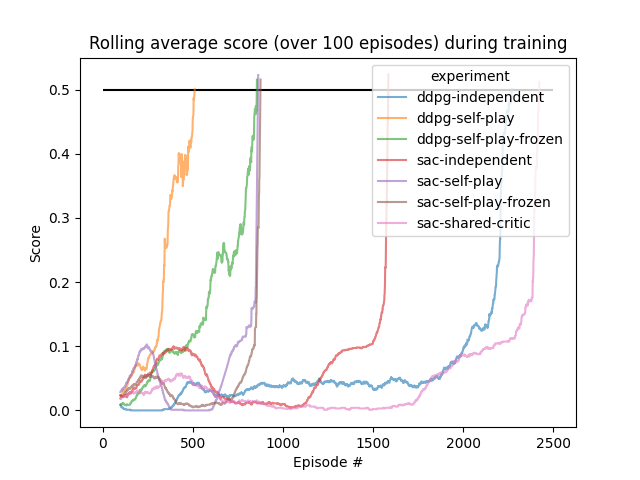

In [15]:
res_pivot = results.pivot_table(index='episode', columns='experiment', values='score', dropna = False)
res_pivot.rolling(100).mean().plot(alpha=0.6)
plt.hlines(0.5, 0, 2500)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Rolling average score (over 100 episodes) during training');


<IPython.core.display.Javascript object>


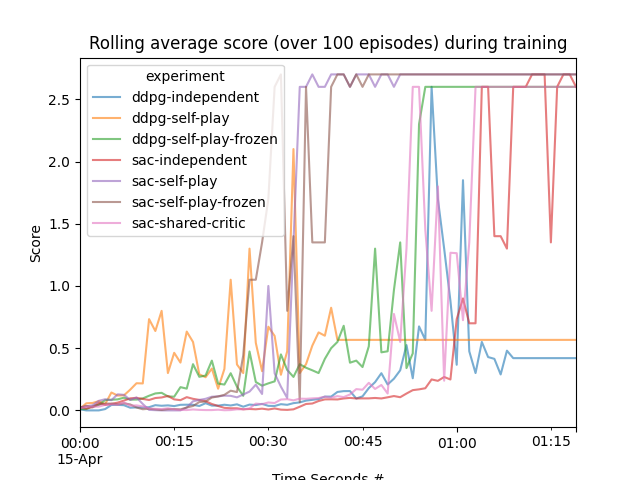

In [16]:
import datetime
time_pivot = results.pivot_table(index='time_seconds', columns='experiment', values='score', dropna = False)
time_pivot.index = pd.Timestamp(datetime.date.today()) + pd.TimedeltaIndex(time_pivot.index, unit='s')
time_pivot = time_pivot.resample('min').mean().ffill()

time_pivot.plot(alpha=0.6)
plt.ylabel('Score')
plt.xlabel('Time Seconds #')
plt.title('Rolling average score (over 100 episodes) during training');

## 7 Future Work

Next steps for this project could be looking into other types of self training policy. We could for example train against a varied population of agents in order to get more robust behaviour. We could also look at using the shared critic model in self training (rather than as a variant on independent training as used here). A more challenging target would be changing the reward function to make the task competitive (via reward function change) as this would allow for more interesting dynamics in the agent interactions.